### Psychometric Model Sampling

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano

min_x = -10
max_x = 10
N = 50 # 10 trials at each orientation
x = np.linspace(min_x, max_x, 21) # the experiment is conducted at 21 x's
x_shared = theano.shared(x)
x_center = (min_x + max_x) / 2
# t = np.linspace(-10, 10, 101)
bias = .8
sensitivity = 1.2

true_params = [sensitivity, bias]
labels_params = ['sensitivity', 'bias']
def plogistic(true_params, x, x_center):
    return 1/(1 + np.exp(-(true_params[1]+true_params[0]*(x-x_center)) ))
p_true = plogistic(true_params, x, x_center)
np.random.seed(1234)
choices = (np.random.uniform(size=[N, np.size(p_true)]) < p_true).T * 1
observed_choices = np.sum(choices, 1)

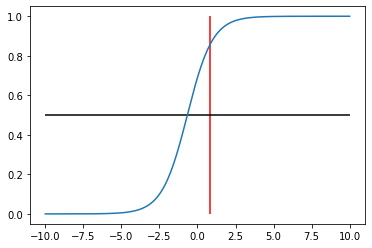

In [17]:
t = np.linspace(-10, 10, 200)

plt.plot(t, plogistic(true_params, t, x_center))
plt.vlines(true_params[1], 0, 1, colors='r')
plt.hlines(.5, -10, 10)

In [18]:
observed_choices, p_true

(array([ 0,  0,  0,  0,  0,  0,  2,  4, 11, 19, 34, 44, 47, 50, 50, 50, 50,
        50, 50, 50, 50]),
 array([1.36740091e-05, 4.53978687e-05, 1.50710358e-04, 5.00201107e-04,
        1.65880108e-03, 5.48629890e-03, 1.79862100e-02, 5.73241759e-02,
        1.67981615e-01, 4.01312340e-01, 6.89974481e-01, 8.80797078e-01,
        9.60834277e-01, 9.87871565e-01, 9.96315760e-01, 9.98887464e-01,
        9.99664650e-01, 9.99898971e-01, 9.99969568e-01, 9.99990834e-01,
        9.99997239e-01]))

In [19]:
np.random.seed(1234)
y_trial = pm.Binomial.dist(n=N, p = p_true)
y_trial.random(size=2)

array([[ 0,  0,  0,  0,  0,  0,  0,  4, 13, 24, 36, 44, 48, 49, 50, 50,
        50, 50, 50, 50, 50],
       [ 0,  0,  0,  0,  0,  0,  2,  2,  9, 24, 35, 42, 49, 49, 50, 50,
        50, 50, 50, 50, 50]])

## Defining the model in PyMC3

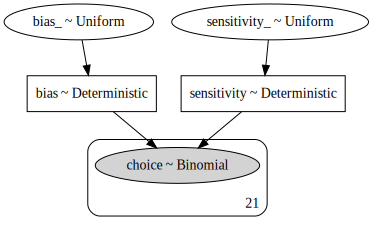

In [20]:
with pm.Model() as psychometricModel:
    
    sensitivity_ = pm.Uniform('sensitivity_', lower = 0, upper =5)
    bias_ = pm.Uniform('bias_', lower = -5, upper = 5)
    
    bias = pm.Deterministic("bias", bias_)
    sensitivity = pm.Deterministic("sensitivity", sensitivity_)
    
    p_ = ( 1/(1 + np.exp(-(bias+sensitivity*(x - x_center)) )))
    np.random.seed(1234)
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Binomial('choice', n=N, p=p_, observed = observed_choices)
pm.model_to_graphviz(psychometricModel)

## MAP Estimate

In [21]:
def find_map(model, params):
    map_estimate = pm.find_MAP(model=model)
    return {params[0]: map_estimate[params[0]].flatten()[0], params[1]: map_estimate[params[1]].flatten()[0]} 

In [30]:
# def find_map(model, params):
map_estimate = pm.find_MAP(model=psychometricModel)

map_estimate

logp = -18.712, ||grad|| = 0.00029206: 100%|██████████| 13/13 [00:00<00:00, 1678.91it/s]  


{'sensitivity__interval__': array(-1.2290681),
 'bias__interval__': array(0.32887357),
 'sensitivity_': array(1.13172286),
 'bias_': array(0.81485274),
 'bias': array(0.81485274),
 'sensitivity': array(1.13172286)}

## NUTS Sampler

In [22]:
def find_nuts(model, params):
    with model:
        trace = pm.sample(draws=2000, tune = 3000)
    return {params[0]: np.mean(trace.get_values(params[0])), params[1]: np.mean(trace.get_values(params[1]))} 

In [29]:
with psychometricModel:
    trace = pm.sample(draws=2000, tune = 3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bias_, sensitivity_]
Sampling 4 chains, 0 divergences: 100%|██████████| 20000/20000 [00:06<00:00, 3208.07draws/s]


In [31]:
ppcs['choice'][1]

NameError: name 'ppcs' is not defined

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a21248c88>,
      dtype=object)

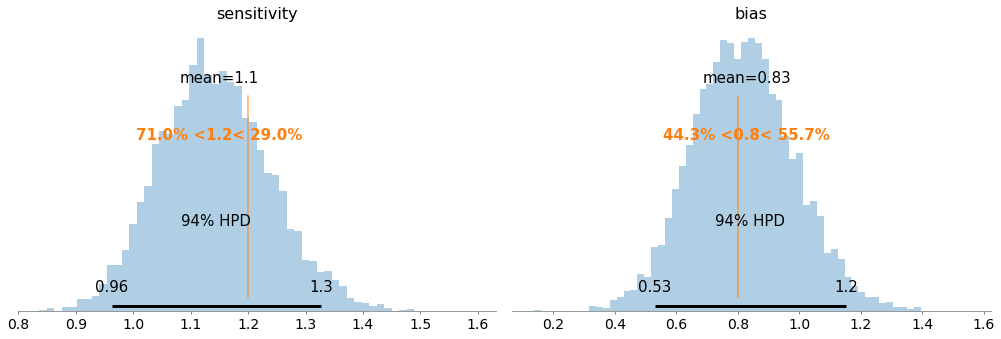

In [32]:
pm.plot_posterior(trace, var_names=['sensitivity', 'bias'], ref_val=list(true_params), kind="%hist")

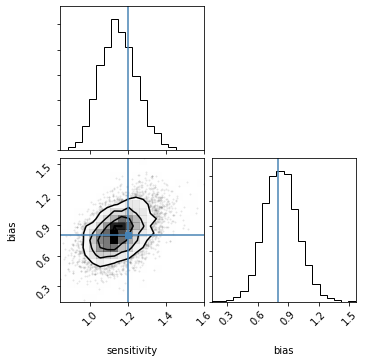

In [34]:
import corner
samples = np.vstack([trace[k] for k in ['sensitivity', 'bias']]).T
corner.corner(samples, truths=true_params, labels=['sensitivity', 'bias']);

/Users/hahuja/opt/anaconda3/envs/bayes3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/hahuja/opt/anaconda3/envs/bayes3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/hahuja/opt/anaconda3/envs/bayes3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/hahuja/opt/anaconda3/envs/bayes3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument b

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a26628c50>,
      dtype=object)

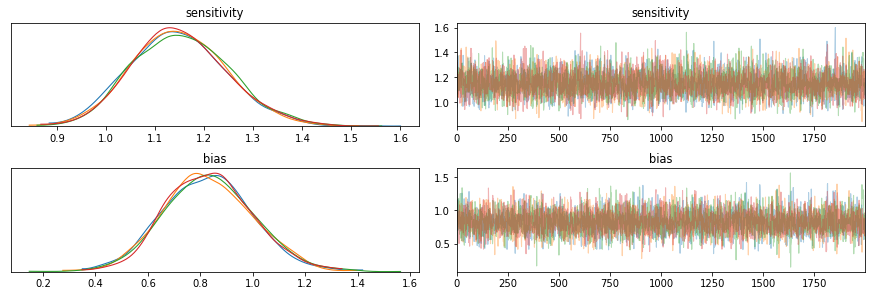

In [35]:
pm.plot_trace(trace, var_names=['sensitivity', 'bias'])

## MCMC

In [36]:
import theano

f = theano.function(psychometricModel.vars, [psychometricModel.logpt] + psychometricModel.deterministics)
    
def log_prob_func(params):
    dct = psychometricModel.bijection.rmap(params)
    args = (dct[k.name] for k in psychometricModel.vars)
    results = f(*args)
    return tuple(results)

In [37]:
import emcee

with psychometricModel:
    # First we work out the shapes of all of the deterministic variables
    res = pm.find_MAP()
vec = psychometricModel.bijection.map(res)
initial_blobs = log_prob_func(vec)[1:]
dtype = [(var.name, float, np.shape(b)) for var, b in zip(psychometricModel.deterministics, initial_blobs)]
    
# Then sample as usual
coords = vec + 1e-5 * np.random.randn(25, len(vec))
nwalkers, ndim = coords.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_func, blobs_dtype=dtype)
sampler.run_mcmc(coords, 5000, progress=True)

logp = -18.712, ||grad|| = 0.00029206: 100%|██████████| 13/13 [00:00<00:00, 2453.25it/s]  
100%|██████████| 5000/5000 [00:08<00:00, 580.64it/s]


State([[ 0.25480275 -1.13964518]
 [ 0.28999635 -1.15804973]
 [ 0.29486584 -1.09346987]
 [ 0.34405506 -1.19970211]
 [ 0.32817942 -1.15159602]
 [ 0.42875494 -1.02882513]
 [ 0.34951379 -1.08286442]
 [ 0.36485818 -1.04902289]
 [ 0.3420679  -1.16207405]
 [ 0.3255135  -1.14019966]
 [ 0.32373755 -1.29322869]
 [ 0.23553409 -1.30216394]
 [ 0.2796806  -1.43727679]
 [ 0.41861157 -1.1223796 ]
 [ 0.2414155  -1.17390425]
 [ 0.51650209 -1.16888036]
 [ 0.25967996 -1.11158188]
 [ 0.3816493  -1.08928592]
 [ 0.33506958 -1.21288454]
 [ 0.25941946 -1.26208354]
 [ 0.3769666  -1.26857595]
 [ 0.24055527 -1.32749771]
 [ 0.36856009 -1.19994652]
 [ 0.37883627 -1.23124365]
 [ 0.20631188 -1.16924161]], log_prob=[-19.41677766 -18.54091992 -19.24161879 -17.98702749 -18.22622685
 -19.75865418 -18.82340041 -19.24157864 -18.11697502 -18.33335274
 -18.18970898 -19.00799888 -20.04376896 -18.84184605 -19.36284668
 -21.6615212  -19.68750253 -18.74142507 -17.96005625 -18.51699094
 -18.50882465 -19.00997732 -18.11426533 -18.

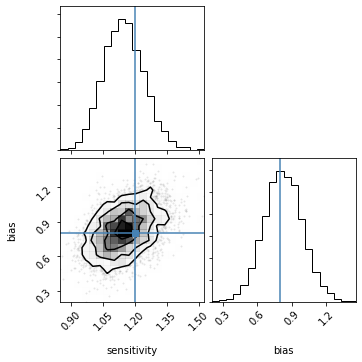

In [38]:
import pandas as pd
df = pd.DataFrame.from_records(sampler.get_blobs(flat=True, discard=100, thin=30))
corner.corner(df[["sensitivity", "bias"]], truths=true_params);

In [39]:
df = pd.DataFrame.from_records(sampler.get_blobs(flat=True, discard=100, thin=30))
means = df.mean(axis=0)
return means[params[0]], means[params[0]]

SyntaxError: 'return' outside function (<ipython-input-39-796e39107605>, line 3)

sensitivity_    1.146619
bias_           0.826168
bias            0.826168
sensitivity     1.146619
dtype: float64

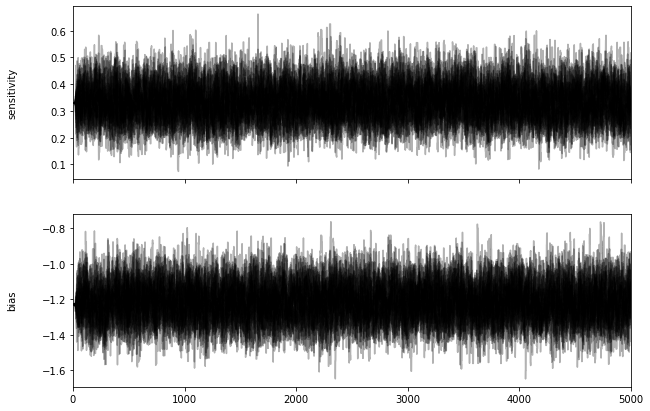

In [43]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["sensitivity", "bias"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha = .3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

In [44]:
tau = sampler.get_autocorr_time()
print(tau)

[33.36845447 32.74345834]


##  MH Sampling

In [45]:
def subjectSimulator(x, x_center, params, seed=None):
    
    sensitivity = params[0];
    bias = params[1];
    p = (1/(1 + np.exp(-(bias+sensitivity*(x-x_center)) )))
    
    choices = (np.random.uniform(size=[N, np.size(p)]) < p).T * 1
    return np.sum(choices, 1)

In [50]:
def sample_proposal(*sigmas):
    return np.random.normal(0., simgas)

def run_metropolis_hastings(p0, n_steps, model, proposal_sigmas, data):
    """
    Input
    --------------
    p0 : iterable 
        Initial param vector
    n_steps: int
        Number of steps to run the sampler for
    model: 
        define a call function which calculates the log posterior
        the generative model that takes the input parameter vector and computes the log of the posterior pdf
    proposal_sigmas: list, array
        A list of standard-deviations
        
    """
    p0 = np.array(p0)
    assert len(proposal_sigmas) == len(p0)

    chain = np.zeros((n_steps, len(p0)))
    ln_probs = np.zeros(n_steps)
    
    n_accept = 0
    
    ln_probs[0] = model(data['x'], data['x_center'], p0)
    chain[0] = p0
    
    # loop through the number of steps requested and run MCMC
    for i in range(1, n_steps):
        # proposed new parameters
        step = sample_proposal(*proposal_sigmas)
        new_p = chain[i-1] + step
        
        new_ln_prob = model(new_p)
        
        ln_prob_ratio = new_ln_prob - ln_probs[i-1]
        
        if (ln_prob_ratio > 0) or (ln_prob_ratio > np.log(np.random.uniform())):
            chain[i] = new_p
            ln_probs[i] = new_ln_prob
            n_accept += 1
        else:
            chain[i] = chain[i-1]
            ln_probs[i] = ln_probs[i-1]
        
    acc_frac = n_accept / n_steps
    return chain, ln_probs, acc_frac

In [51]:
p0 = [6., 6.]
data = {'x': x, 'x_center': x_center}
chain,_,acc_frac = run_metropolis_hastings(p0, n_steps=8192, model=subjectSimulator, 
                                           proposal_sigmas=[0.05,0.05], data = data)

ValueError: setting an array element with a sequence.